<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: María Paz Raveau Morales</em><br>

</div>

# **<center>TAREA 1 MINERÍA DE TEXTO (NLP)</center>**
## <center>Extrayendo contenido útil y visualizando</center>
*20 de julio de 2025*

**Nombre Estudiante**: Cristian Tobar Morales  
**Asignatura**: Procesamiento de Lenguaje Natural


## **DESCRIPCIÓN DE LA PROBLEMÁTICA**
Suponga que ud. es contactado por alguna agencia gubernamental que quiere saber qué dijeron los participantes de los cabildos de 2016. Ud. debe entonces, basándose en los textos de fundamento, responder a este requerimiento.  Use para ello la base de datos que vimos en clases, de los cabildos provinciales. 

## **DESARROLLO**

### **CARGA Y ANÁLISIS EXPLORATORIO DE LOS DATOS**

#### Librerías requeridas

In [132]:
import pandas as pd
import numpy as np
import os

# Librerías de Procesamiento de Texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import stanza
import string
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk import bigrams

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('punkt') # Ejecutar solamente una vez

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
stanza.download('es') # Ejecutar solamente una vez
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

2025-07-20 16:49:23 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-07-20 16:49:23 INFO: Downloading default packages for language: es (Spanish) ...
2025-07-20 16:49:25 INFO: File exists: C:\Users\crist\stanza_resources\es\default.zip
2025-07-20 16:49:33 INFO: Finished downloading models and saved to C:\Users\crist\stanza_resources
2025-07-20 16:49:33 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-07-20 16:49:33 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-07-20 16:49:34 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-07-20 16:49:34 INFO: Using device: cpu
2025-07-20 16:49:34 INFO: Loading: tokenize
2025-07-20 16:51:01 INFO: Loading: mwt
2025-07-20 16:51:01 INFO: Loading: pos
2025-07-20 16:51:04 INFO: Loading: lemma
2025-07-20 16:51:06 INFO: Loading: depparse
2025-07-20 16:51:06 INFO: Done loading processors!


#### Cargar e Información inicial del dataset

In [4]:
# Cargar los datos
url = "resultadocabildoprovincial.xlsx"
df = pd.read_excel(url)

In [5]:
# Dimensiones de los datos (Filas, columnas):
print("\u001b[1mDIMENSIONES\u001b[0m")
print("Filas:",df.shape[0]) # type: ignore
print("Columnas:",df.shape[1],"\n") # type: ignore

DIMENSIONES
Filas: 30414
Columnas: 12 



In [6]:
# Exploración inicial
df.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Autonomía/libertad,NaN,A,sin fundamento
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Equidad de género,NaN,A,Sin fundamento
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Respeto/conservación de la naturaleza o medio ...,NaN,A,Sin fundamento


In [7]:
# Información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30414 entries, 0 to 30413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region_nombre      30414 non-null  object
 1   provincia_nombre   30414 non-null  object
 2   comuna_nombre      30414 non-null  object
 3   cabildo_id         30414 non-null  int64 
 4   cabildo_nombre     30414 non-null  object
 5   cabildo_direccion  30414 non-null  object
 6   num_mesa           30414 non-null  int64 
 7   pregunta_glosa     30414 non-null  object
 8   concepto_nombre    30414 non-null  object
 9   concepto_otro      7121 non-null   object
 10  tipo-eleccion      30414 non-null  object
 11  fundamento         30414 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.8+ MB


Se observa que las columnas de interés `concepto_nombre` y `fundamento`, no presenta valores nulos.

#### Selección de concepto
Antes de seleccionar el concepto, de la columna `fundamento` se procederá eliminar las columnas que tienen texto duplicado, ya se las que dice "sin fundamento".

In [21]:
# Se contara la cantidad
df['concepto_nombre'].value_counts().head(15)

concepto_nombre
Otro                                                                       7121
Igualdad                                                                    649
Justicia                                                                    619
A la salud                                                                  614
A la educación                                                              611
Descentralización                                                           610
Respeto/conservación de la naturaleza o medio ambiente                      607
Democracia                                                                  604
Plebiscitos, referendos y consultas                                         597
Protección, promoción y respeto de los derechos humanos y fundamentales     582
Respeto por la constitución                                                 567
Deberes de protección de conservación de la naturaleza                      565
Defensor del Pueblo/Ciud

Se selecciona el `concepto salud` para dicho estudio, debido a que presenta un interes en particular y cuenta con gran catidad de fundamentos.

In [22]:
# Crear un nuevo df y filtrar por salud
df_salud =df[df['concepto_nombre'] == 'A la salud']

# Mostrar Tabla
df_salud['fundamento'].head(5).to_list()

['Sin fundamento',
 'sin fundamento',
 'Esperan a que las personas enfermen para recibir ayuda. Necesitamos salud preventiva. Desaparición de la Isapre.',
 'se le agrega el concepto salud digna',
 'Garantizar el derecho y acceso a una salud universal\nPotenciar la salud estatal\nOptimización de los recursos y tecnologías \nMejorar la prevención en salud']

### **PRE-PROCESAMIENTO DEL DATAFRAME**

Primeramente, se debe observar de la columna `fundamento`, cuales filas no aportar información relevante para el estudio, dicho caso se procede a eliminar.
Se crea un nueva columna `fundamento_modifcado`, con el objetivo de no alterar la columna original.

In [25]:
columna = 'fundamento_modificado'

# Crear una nueva columna
df_salud[columna]= df_salud['fundamento']

# Saber que entradas no aportan información
df_salud[columna].value_counts().head(10)

C:\Users\crist\AppData\Local\Temp\ipykernel_11708\234907178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salud[columna]= df_salud['fundamento']


fundamento_modificado
.                  21
Sin fundamento     15
sin fundamento     14
SIN FUNDAMENTO     10
Sin Fundamento      9
-                   6
Acuerdo.            5
Sin fundamentos     4
Sin fundamento.     4
sin fundamentos     4
Name: count, dtype: int64

In [26]:
print("\u001b[1mDIMENSIONES\u001b[0m")
df_salud.shape

DIMENSIONES


(614, 13)

In [30]:
# Obtner los valores únicos
df_salud.drop_duplicates(
    subset=[columna],
    keep='first',      # conserva la primera ocurrencia
    inplace=True
)
df_salud.reset_index(drop=True, inplace=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_11708\2921622052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salud.drop_duplicates(


In [33]:
print("\u001b[1mDIMENSION COLUMNA\u001b[0m")
df_salud[columna].count()

DIMENSION COLUMNA


512

#### Tokenizar
El texto de la columna fundamento se tokeniza del siguiente modo: primero se convierte la columna en una lista de cadenas (**.to_list**); luego se unen todos los elementos en un único string separados por espacios (**.join**); a continuación se aplica **word_tokenize** al texto resultante; después se obtienen los tokens únicos mediante un set; y finalmente se devuelve la cantidad de dichos tokens únicos (**len**).

In [34]:
corpus =' '.join(df_salud[columna].to_list())
doc = set(word_tokenize(corpus))
largo= len(doc)
#Imprimir
print("Tokens únicos:", largo)

Tokens únicos: 1671


#### Lemmatizar

porque bueno lematizar al comienzo?
Es recomendable lemaitzar al comienzo porque entiende el lenguaje natural.

In [35]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([x.lemma for x in doc.sentences[0].words])

In [36]:
df_salud['lemmas'] = df_salud[columna].apply(lemmatizer)

C:\Users\crist\AppData\Local\Temp\ipykernel_11708\26831423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salud['lemmas'] = df_salud[columna].apply(lemmatizer)


In [37]:
len(set(word_tokenize(' '.join(df_salud['lemmas'].to_list()))))

893

Se procede a transformar el texto en minúsculas, eliminar puntuaciones, números, espacios en blanco y saldo de líneas. 

In [38]:
# Transformar a minúscula
df_salud['lemmas'] = df_salud['lemmas'].str.lower()

# Eliminar las puntuaciones: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
df_salud['lemmas'] = df_salud['lemmas'].str.translate(str.maketrans('','', string.punctuation))

# Eliminar números
df_salud['lemmas'] = df_salud['lemmas'].str.translate(str.maketrans('', '', string.digits))

# Eliminar espacios en blanco
df_salud['lemmas'] = df_salud['lemmas'].str.strip()

# Reemplazar saltos de líneas por espacios
df_salud['lemmas'] = df_salud['lemmas'].str.replace('\n',' ')

C:\Users\crist\AppData\Local\Temp\ipykernel_11708\3906025568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salud['lemmas'] = df_salud['lemmas'].str.lower()
C:\Users\crist\AppData\Local\Temp\ipykernel_11708\3906025568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salud['lemmas'] = df_salud['lemmas'].str.translate(str.maketrans('','', string.punctuation))
C:\Users\crist\AppData\Local\Temp\ipykernel_11708\3906025568.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [39]:
len(set(word_tokenize(' '.join(df_salud['lemmas'].to_list()))))

820

In [42]:
df_salud['lemmas'].value_counts().head(20)

lemmas
sin fundamento                                                                                                                                                       12
                                                                                                                                                                      7
derecho fundamental                                                                                                                                                   4
sin fundamentación                                                                                                                                                    3
acta sin fundamento                                                                                                                                                   3
acuerdo                                                                                                                                                  

Se observa al contar los iguales de las columna `lemmas`, la mayoría de las variables poseen un largo igual o menor a 3 palabras, es por eso se procederá a eliminar dichas filas.

In [60]:
# Seleccionar mayor a 3
buscar = df_salud['lemmas'].str.split().str.len() > 3

# Resetear index
df_filtrado = df_salud.loc[buscar].reset_index(drop=True)

# Mostrar
df_filtrado['lemmas'].value_counts().head()

lemmas
esperar a que el persona enfermar para recibir ayuda                                                                                                                 1
ser fundamental para a vida de el persona deber fiscalizar él el como él utilizar el planta destinado a el salud deberar ser estatal deber ser de calidad            1
estado tener que ser el garante de este derecho                                                                                                                      1
el grupo a el tratar cada tema considerar estar de acuerdo con el ranking  por él mismo ser que no él estipular definición o fundamento para determinado concepto    1
que él garantizar  que él cumplir                                                                                                                                    1
Name: count, dtype: int64

In [78]:
df_filtrado['lemmas'].value_counts().head(30)

lemmas
esperar a que el persona enfermar para recibir ayuda                                                                                                                                                                                                                                                           1
ser fundamental para a vida de el persona deber fiscalizar él el como él utilizar el planta destinado a el salud deberar ser estatal deber ser de calidad                                                                                                                                                      1
estado tener que ser el garante de este derecho                                                                                                                                                                                                                                                                1
el grupo a el tratar cada tema considerar estar de acuerdo con el ranking  por

#### Stopwords

In [61]:
esp_stop = stopwords.words('spanish')

In [62]:
# Tokenizar el texto
tokens = set(word_tokenize(' '.join(df_filtrado['lemmas'].to_list())))

In [63]:
# Eliminar Stopwords
vocab = [x for x in tokens if x not in esp_stop]

In [64]:
len(vocab)

745

### WORDCLOUD

In [68]:
toks = []

for frase in df_filtrado['lemmas']:
    tokens = word_tokenize(frase) # Tokenizar
    tokens = [x for x in tokens if x not in esp_stop] # Stopwords
    toks.extend(tokens)

In [69]:
from collections import Counter

freqs = Counter(toks)
# Mostrar los 10 más comunes
print(freqs.most_common(10))

[('salud', 210), ('calidad', 191), ('ser', 137), ('derecho', 132), ('deber', 112), ('acceso', 85), ('gratuito', 70), ('garantizar', 63), ('digno', 59), ('público', 47)]


In [70]:
len(toks)

2934

Se procede a eliminar las palabras `ser` y `deber` del listado, debido a que no presenta relevancia al análisis.

In [83]:
toks = [x for x in toks if x != 'ser']
toks = [x for x in toks if x != 'deber']

print(Counter(toks).most_common(5))

[('salud', 210), ('calidad', 191), ('derecho', 132), ('acceso', 85), ('gratuito', 70)]


In [80]:
len(toks)

2685

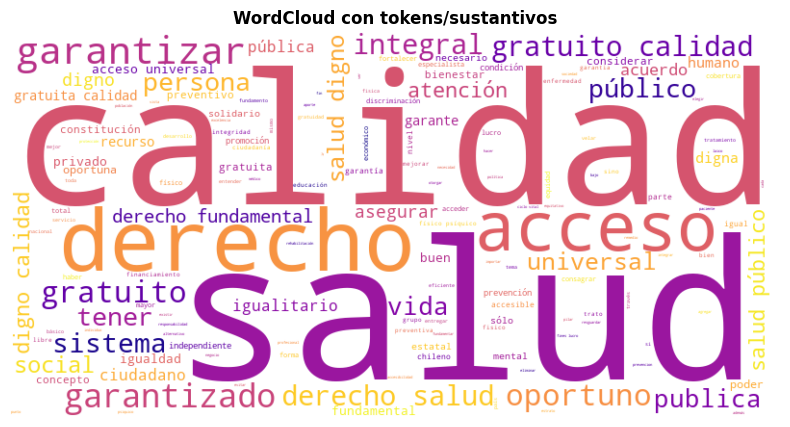

In [86]:
# 1. Unir la lista de tokens
texto = ' '.join(toks)

wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=2797,
    colormap='plasma'
).generate(texto)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud con tokens/sustantivos', fontsize=12, fontweight='bold')
plt.show()

### BIGRAMAS

In [88]:
bigramas= []

for frase in df_filtrado['lemmas']:
    tokens = word_tokenize(frase) # Tokenizar
    tokens = [x for x in tokens if x not in esp_stop] # Stopwords
    if len(tokens)> 1:
        bigram_tokens = [' '.join(x) for x in list(bigrams(tokens))]
    
    bigramas.extend(bigram_tokens)

In [91]:
print(Counter(bigramas).most_common(5))

[('deber ser', 36), ('gratuito calidad', 32), ('derecho salud', 31), ('deber garantizar', 29), ('salud calidad', 24)]


Se procede a eliminar el bigrama de `deber ser`, ya que no presenta relevancia al estudio. 

In [93]:
bigramas = [x for x in bigramas if x != 'deber ser']
print(Counter(bigramas).most_common(5))

[('gratuito calidad', 32), ('derecho salud', 31), ('deber garantizar', 29), ('salud calidad', 24), ('salud digno', 22)]


In [94]:
len(bigramas)

2491

In [ ]:
bigram_df = pd.DataFrame(list(bigramas), columns=['ngram'])
bigram_df.head()

,ngram
0,esperar persona
1,persona enfermar
2,enfermar recibir
3,recibir ayuda
4,agregar concepto


In [119]:
bigram_df['ngram']=bigram_df['ngram'].str.split()
bigram_df.head()

,ngram
0,"[esperar, persona]"
1,"[persona, enfermar]"
2,"[enfermar, recibir]"
3,"[recibir, ayuda]"
4,"[agregar, concepto]"


In [129]:
# crear una columna 'pair' como "esperar_persona", transofrmas en string
bigram_df['pair'] = bigram_df['ngram'].apply(lambda lst: '-'.join(lst))

# contar las ocurrencias de cada string
conteo = (
  bigram_df['pair']
    .value_counts()
    .reset_index(name='frecuencia')
)

In [130]:
conteo.head()

,pair,frecuencia
0,gratuito-calidad,32
1,derecho-salud,31
2,deber-garantizar,29
3,salud-calidad,24
4,ser-derecho,22


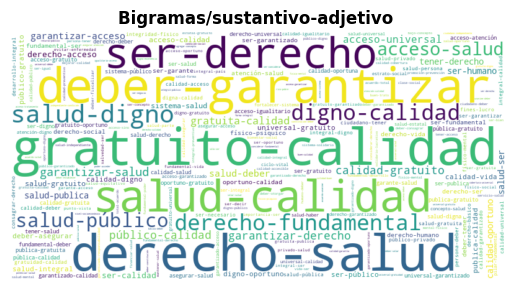

In [131]:
# Visualizando
freq_dict = dict(zip(conteo['pair'], conteo['frecuencia']))

wc_big = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=2491,
).generate_from_frequencies(freq_dict)

plt.Figure(figsize=(10, 10))
plt.imshow(wc_big, interpolation='bilinear')
plt.axis('off')
plt.title('Bigramas/sustantivo-adjetivo ', fontsize=12, fontweight='bold')
plt.show()

### RED DE BIGRAMAS

In [152]:
# Crear nuevas columnas
conteo[['sustantivo', 'adjetivo']] = (
    conteo['pair']
    .str.split('-', n=1, expand=True)
)
conteo.head()

,pair,frecuencia,sustantivo,adjetivo
0,gratuito-calidad,32,gratuito,calidad
1,derecho-salud,31,derecho,salud
2,deber-garantizar,29,deber,garantizar
3,salud-calidad,24,salud,calidad
4,ser-derecho,22,ser,derecho


In [153]:
# montar el grafo
G = nx.Graph()

for _, row in conteo.iterrows():
    u = row['sustantivo']
    v = row['adjetivo']
    w = row['frecuencia']
    G.add_edge(u, v, weight= w)

In [154]:
for u, v, d in G.edges(data=True):
    print((u, v, d))
    break


('gratuito', 'calidad', {'weight': 14})


d:\crist\OneDrive\Estudios\Mg Data Science_2024\Trimestre 5\Procesamiento de lenguaje natural\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


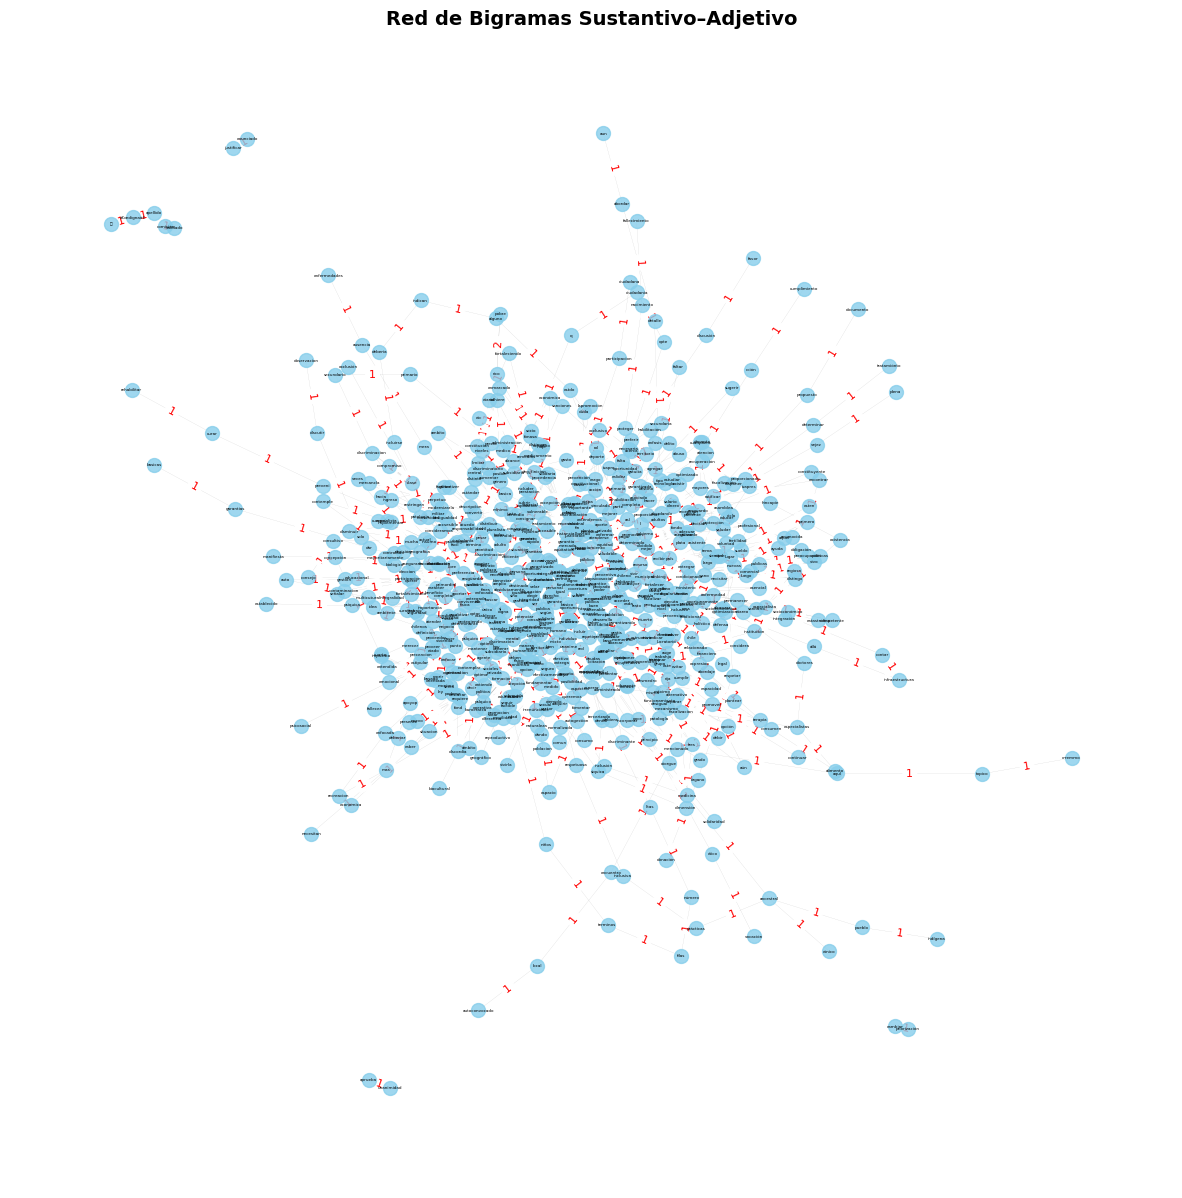

In [155]:
# Visualizar
plt.figure(figsize=(15,15))

pos = nx.spring_layout(G, seed=42, k=0.5) # Posicionar nodos
 


# Layout para posicionar nodos
pos = nx.spring_layout(G, seed=42, k=0.5)


# Ancho de aristas según peso
widths = [d['weight'] * 0.1 for (_,_,d) in G.edges(data=True)]

nx.draw_networkx_nodes(
    G, pos,
    node_size=100,
    node_color='skyblue',
    alpha=0.8
)
nx.draw_networkx_edges(
    G, pos,
    width=widths,
    edge_color='gray',
    alpha=0.6
)
nx.draw_networkx_labels(
    G, pos,
    font_size=3,
    font_family='sans-serif'
)


#Etiquetas de arista: muestra la frecuencia sobre cada línea
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=8,
    label_pos=0.5,   # 0.5 = mitad de la arista
    font_color='red'
)

plt.title('Red de Bigramas Sustantivo–Adjetivo', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()



### Ayúdese con frases de ejemplo, y de los WordClouds, para escribir una descripción del concepto. 

La salud publica es esencial para el bienestar de las personas, debe ser garantizada como acceso universal, el sistema de salud es un derecho para todos. 